IMPORT THE NECCESARY LIBRARIES

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import joblib

SINCE WE HAVE NO DATASET, WE'D HAVE TO CREATE A SYNTHETIC DATASET

In [2]:
# set a random seed with numpy
np.random.seed(42)

# We ned to specify the number of samples
samples = 1000

# We have to simulate the dataset based on the required infromation
data = {
    "CustomerID": range(1, samples + 1),
    "Age": np.random.randint(18, 70, size=samples),
    "Gender": np.random.choice(["Male", "Female"], size=samples),
    "Location": np.random.choice(["Urban", "Suburban", "Rural"], size=samples),
    "Tenure": np.random.randint(1, 120, size=samples),
    "AvgTransactionFrequency": np.random.uniform(1, 15, size=samples),
    "LastTransactionDays": np.random.randint(1, 365, size=samples),
    "TotalSpending": np.random.uniform(100, 10000, size=samples),
    "EngagementScore": np.random.uniform(0, 100, size=samples),
    "EmailOpenRate": np.random.uniform(0, 1, size=samples),
    "TimeSpentOnPlatform": np.random.uniform(0.5, 50, size=samples),
    "IsSubscribed": np.random.choice([1, 0], size=samples, p=[0.6, 0.4]),
    "Churned": np.random.choice([1, 0], size=samples, p=[0.2, 0.8])
}

# Then we have to create the dataframe
data = pd.DataFrame(data)

# To save the dataset
data.to_csv("synthetic_churn_dataset.csv", index = False)

print("Synthetic dataset created and saved")

Synthetic dataset created and saved


WE HAVE TO PRINT THE FIRST 5 ROWS OF THE DATASET

In [5]:
data = pd.read_csv("synthetic_churn_dataset.csv")
data.head(5)

,CustomerID,Age,Gender,Location,Tenure,AvgTransactionFrequency,LastTransactionDays,TotalSpending,EngagementScore,EmailOpenRate,TimeSpentOnPlatform,IsSubscribed,Churned
0,1,56,Male,Urban,107,13.786017,94,1396.640056,76.874713,0.759520,32.872714,0,0
1,2,69,Male,Suburban,58,9.576029,222,6099.369976,6.194652,0.205988,31.119965,0,0
2,3,46,Male,Urban,5,13.231780,204,8509.519422,57.680792,0.709296,15.837432,1,0
3,4,32,Female,Suburban,5,11.135623,138,545.468530,11.921044,0.021150,4.746817,0,0
4,5,60,Male,Urban,94,2.687818,300,7368.097465,3.646105,0.418933,5.001305,0,0


DATA PREPROCESSING STAGE

In [7]:
# check for missing values
data.isnull().sum()

CustomerID                 0
Age                        0
Gender                     0
Location                   0
Tenure                     0
AvgTransactionFrequency    0
LastTransactionDays        0
TotalSpending              0
EngagementScore            0
EmailOpenRate              0
TimeSpentOnPlatform        0
IsSubscribed               0
Churned                    0
dtype: int64

In [9]:
# Check for the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               1000 non-null   int64  
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Location                 1000 non-null   object 
 4   Tenure                   1000 non-null   int64  
 5   AvgTransactionFrequency  1000 non-null   float64
 6   LastTransactionDays      1000 non-null   int64  
 7   TotalSpending            1000 non-null   float64
 8   EngagementScore          1000 non-null   float64
 9   EmailOpenRate            1000 non-null   float64
 10  TimeSpentOnPlatform      1000 non-null   float64
 11  IsSubscribed             1000 non-null   int64  
 12  Churned                  1000 non-null   int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 101.7+ KB


In [11]:
# encode categorical values
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['Location'] = data['Location'].map({'Urban': 0, 'Suburban': 1, 'Rural': 2})

In [14]:
# Remove duplicate if any
data.drop_duplicates(inplace=True)

In [15]:
# Standardize numerical features
scaler = StandardScaler()

# assign the numerical features into a variabole numerical features
numerical_features = ["AvgTransactionFrequency", "TotalSpending", "EngagementScore", "TimeSpentOnPlatform"]
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [16]:
data.head()

,CustomerID,Age,Gender,Location,Tenure,AvgTransactionFrequency,LastTransactionDays,TotalSpending,EngagementScore,EmailOpenRate,TimeSpentOnPlatform,IsSubscribed,Churned
0,1,56,0,0,107,1.446677,94,-1.265127,0.932307,0.759520,0.599282,0,0
1,2,69,0,1,58,0.401194,222,0.400771,-1.509352,0.205988,0.474965,0,0
2,3,46,0,0,5,1.309041,204,1.254544,0.269249,0.709296,-0.608977,1,0
3,4,32,1,1,5,0.788495,138,-1.566647,-1.311533,0.021150,-1.395600,0,0
4,5,60,0,0,94,-1.309382,300,0.850206,-1.597392,0.418933,-1.377550,0,0


FEATURE ENGINEERING

In [17]:
# We need to create new feature named ChurnRiskScore and this would by multiplying the columns of the EnagagementScore by that of the Tenure, then we divide the values by that of the LastTransactionDays
data["ChurnRiskScore"] = (data["EngagementScore"] * data["Tenure"]) / data["LastTransactionDays"]

# Then we drop the non-informative column
data.drop(["CustomerID"], axis=1, inplace=True)

EXPLORATORY DATA ANALYSIS (EDA)

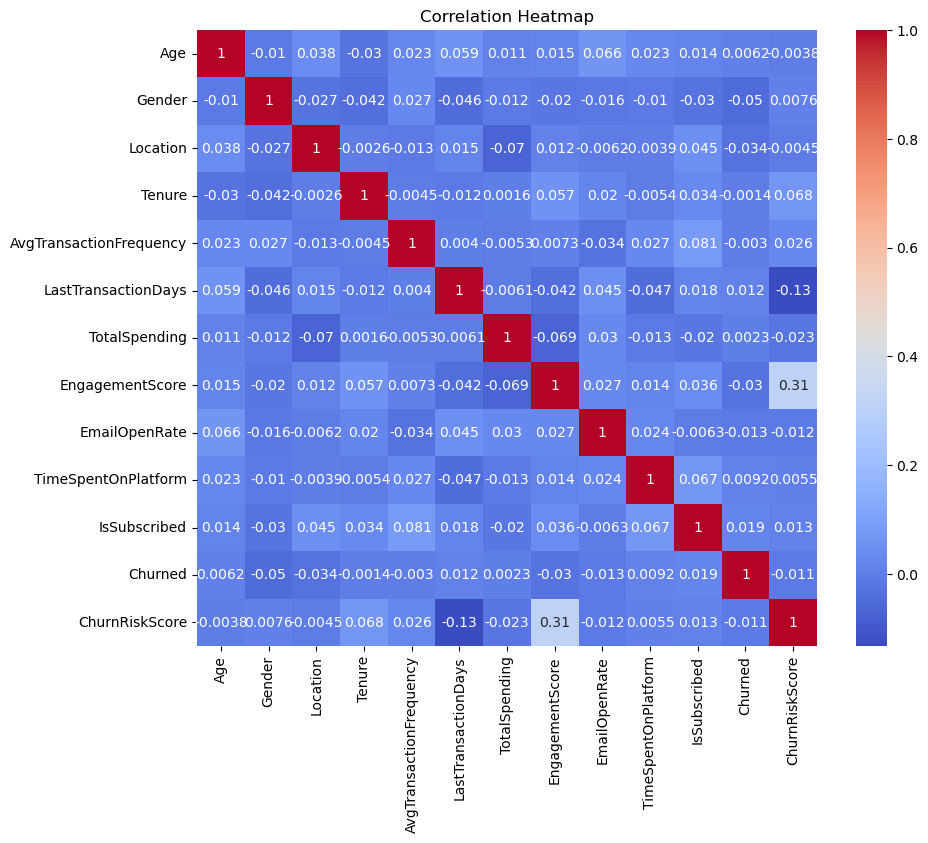

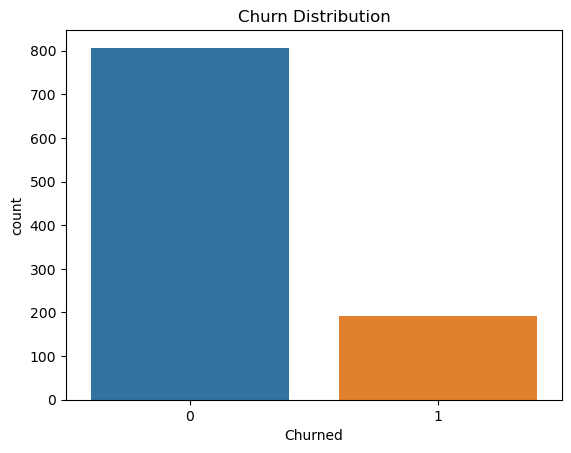

In [19]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribution of churn
sns.countplot(x="Churned", data=data)
plt.title("Churn Distribution")
plt.show()

MODEL DEVELOPMENT

In [20]:
# splitting of the data
X = data.drop("Churned", axis=1)
y = data["Churned"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [21]:
# Handling of imbalanced class
X_train_resampled, y_train_resampled = resample(
    X_train[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train[y_train == 0].shape[0],
    random_state=42
)

X_train = pd.concat([X_train[y_train == 0], X_train_resampled])
y_train = pd.concat([y_train[y_train == 0], y_train_resampled])

In [22]:
# Training of the model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Evaulaton on the test data
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       242
           1       0.33      0.02      0.03        58

    accuracy                           0.80       300
   macro avg       0.57      0.50      0.46       300
weighted avg       0.72      0.80      0.72       300



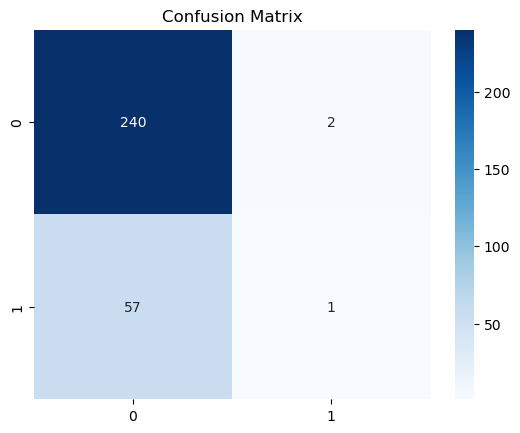

In [23]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd', cmap = 'Blues')
plt.title("Confusion Matrix")
plt.show()

In [24]:
# ROC_AUC 
y_prob = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

ROC-AUC Score: 0.5044884582502137


TO SAVE THE MODEL

In [26]:
joblib.dump(model, "churn_model.pkl")
print("Model saved successfully")

Model saved successfully


FEATURE IMPORTANCE VISUALIZATION

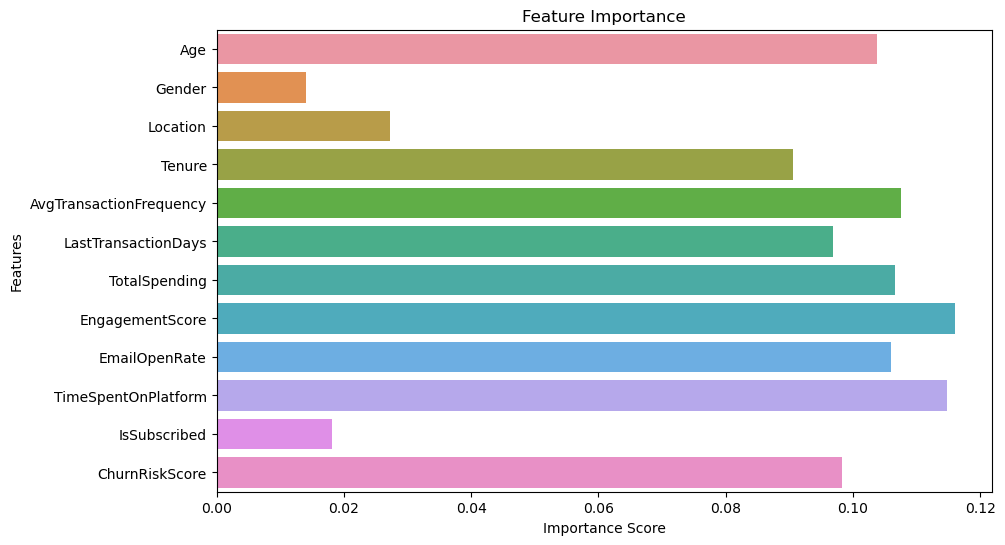

In [27]:
# Plot feature importance
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


SUMMARIZING THE PERFORMANCE METRICS

In [ ]:
# Print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.80
Precision: 0.33
Recall: 0.02
F1 Score: 0.03
